<a href="https://colab.research.google.com/github/arenalmeida/designoptimization/blob/main/final_project1_MAE598.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# project 1 Rocket Landing
# Aren Almeida 1225408288
# importing necessary libraries
import logging
import math
import random
import numpy as np
import time
import torch
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
import scipy.io

torch.manual_seed(10)

logger = logging.getLogger(__name__)

# using intial condition
dx_ini = random.random()  # initial position of rocket on x axis
vx_ini = random.random()  # initial velocity of rocket on x component
dy_ini = random.random()  # initial position of rocket on y axis
vy_ini = random.random()  # initial velocity of rocket on y component
theta = math.pi / 3  # initial angle deviation of rocket axis from y axis
FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity
BOOST_ACCEL = 0.18  # thrust
DRAG_ACCEL = 0.005  # drag

In [2]:
# dynamics used
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):

        delta_state_gravity = torch.tensor([0., 0., 0., -GRAVITY_ACCEL * FRAME_TIME, 0.])
        # converting to tensors
        N = len(state)
        state_tensor = torch.zeros((N, 5))
        state_tensor[:, 1] = -torch.sin(state[:, 4])
        state_tensor[:, 3] = torch.cos(state[:, 4])
        delta_state = BOOST_ACCEL * FRAME_TIME * torch.mul(state_tensor, action[:, 0].reshape(-1, 1))

        #regarding Theta
        delta_state_theta = FRAME_TIME * torch.mul(torch.tensor([0., 0., 0., 0, -1.]), action[:, 1].reshape(-1, 1))

        state = state + delta_state + delta_state_gravity + delta_state_theta

        # Updating state
        step_mat = torch.tensor([[1., FRAME_TIME, 0., 0., 0.],
                                 [0., 1., 0., 0., 0.],
                                 [0., 0., 1., FRAME_TIME, 0.],
                                 [0., 0., 0., 1., 0.],
                                 [0., 0., 0., 0., 1.]])

        state = torch.matmul(step_mat, state.T)

        return state.T

In [3]:
# class controller defined
class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):

        super(Controller, self).__init__()
        # little linear network with ReLU for embeddings
        self.network = nn.Sequential(nn.Linear(dim_input, dim_hidden),nn.Tanh(),nn.Linear(dim_hidden, dim_output),nn.Sigmoid())

    def forward(self, state):
        action = self.network(state)
        return action

In [4]:
# simulating the controller
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T, N):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.N = N
        self.theta_trajectory = torch.empty((1, 0))
        self.u_trajectory = torch.empty((1, 0))

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        
        state = torch.rand((N, 5))
        # initial velocity of rocket on x component = 0
        state[:, 1] = 0  
        # initial velocity of rocket on y component = 0
        state[:, 3] = 0  
        
        return torch.tensor(state, requires_grad=False).float()

    def error(self, state):
        return torch.mean(state ** 2)

In [5]:
# using optimization function
class Optimize:

    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
#method used LBFGS
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01) 
        self.loss_list = []

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss

        self.optimizer.step(closure)
        return closure()

    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            self.loss_list.append(loss)
            print('[%d] loss: %.3f' % (epoch + 1, loss))
        self.visualize()

    def visualize(self):
        data = np.array([[self.simulation.state_trajectory[i][N].detach().numpy() for i in range(self.simulation.T)] for N in range(self.simulation.N)])
        for i in range(self.simulation.N):
            dx = data[i, :, 0]
            dy = data[i, :, 2]
            vx = data[i, :, 1]
            vy = data[i, :, 3]
            theta = data[i, :, 4]
#plotting different graphs for rocket landing parameters
            fig1, axs0 = plt.subplots()
            fig2, axs1 = plt.subplots()
            fig3, axs2 = plt.subplots()
            fig4, axs3 = plt.subplots()
            axs0.plot(dx, dy)
            axs0.set_title('Position for Rocket Landing')
            axs0.set_xlabel('Rocket X Position(in meters)')
            axs0.set_ylabel('Rocket Y Position(in meters)')

            axs1.plot(list(range(self.simulation.T)), vx)
            axs1.set_title('Velocity along X for Rocket Landing')
            axs1.set_xlabel('Time')
            axs1.set_ylabel(' X direction Velocity(m/s)')

            axs2.plot(list(range(self.simulation.T)), vy)
            axs2.set_title('Velocity along Y for Rocket Landing')
            axs2.set_xlabel('Time')
            axs2.set_ylabel('Y direction Velocity(m/s)')

            axs3.plot(list(range(self.simulation.T)), theta)
            axs3.set_title('Angle for Rocket Landing')
            axs3.set_xlabel('Time')
            axs3.set_ylabel('Rocket Angle (in radian)')
        plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[1] loss: 2.398
[2] loss: 1.450
[3] loss: 1.051
[4] loss: 0.794
[5] loss: 0.611
[6] loss: 0.478
[7] loss: 0.350
[8] loss: 0.244
[9] loss: 0.166
[10] loss: 0.111
[11] loss: 0.071
[12] loss: 0.048
[13] loss: 0.034
[14] loss: 0.025
[15] loss: 0.019
[16] loss: 0.015
[17] loss: 0.011
[18] loss: 0.009
[19] loss: 0.008
[20] loss: 0.006
[21] loss: 0.005
[22] loss: 0.005
[23] loss: 0.004
[24] loss: 0.004
[25] loss: 0.003
[26] loss: 0.003
[27] loss: 0.003
[28] loss: 0.003
[29] loss: 0.003
[30] loss: 0.003
[31] loss: 0.002
[32] loss: 0.002
[33] loss: 0.002
[34] loss: 0.002
[35] loss: 0.002
[36] loss: 0.002
[37] loss: 0.002
[38] loss: 0.002
[39] loss: 0.002
[40] loss: 0.002
[41] loss: 0.002
[42] loss: 0.002
[43] loss: 0.002
[44] loss: 0.002
[45] loss: 0.002
[46] loss: 0.002
[47] loss: 0.002
[48] loss: 0.002
[49] loss: 0.002
[50] loss: 0.002


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

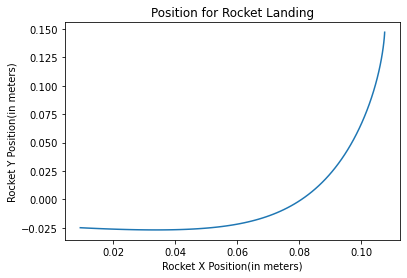

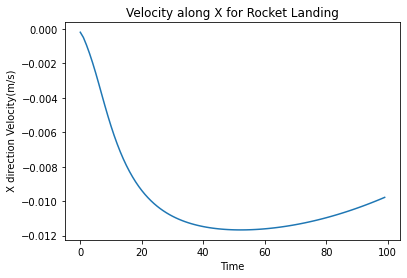

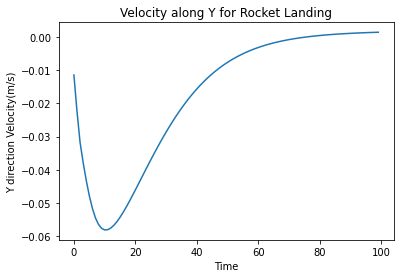

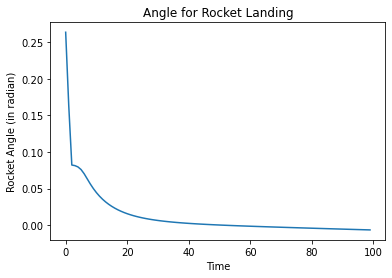

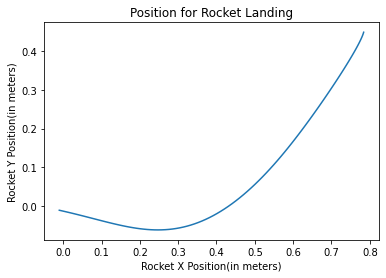

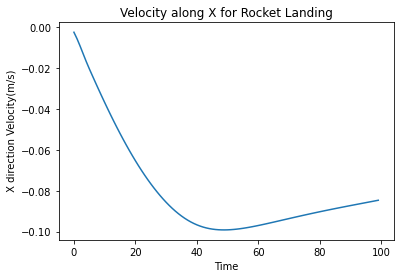

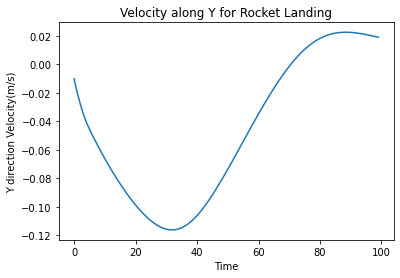

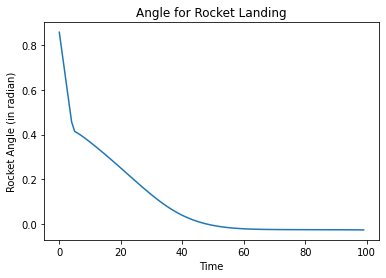

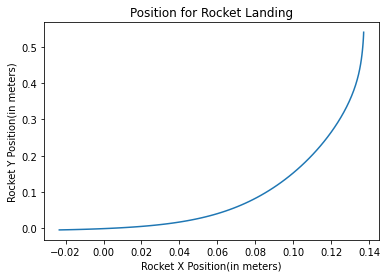

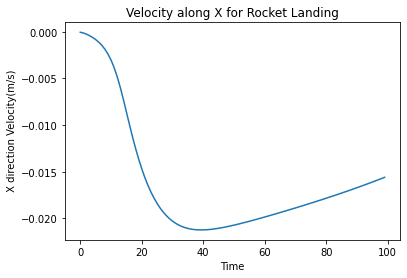

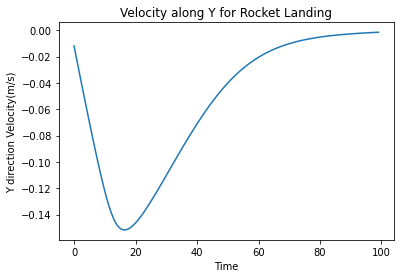

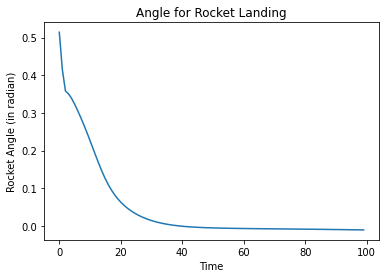

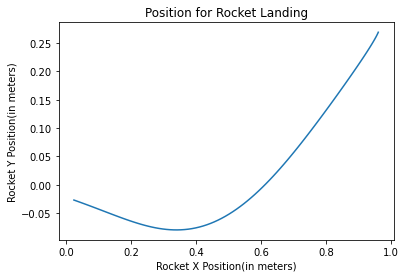

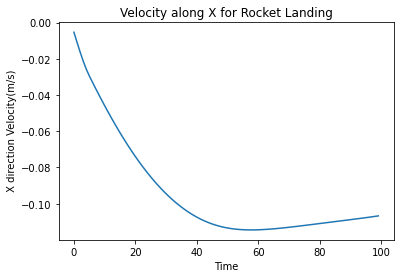

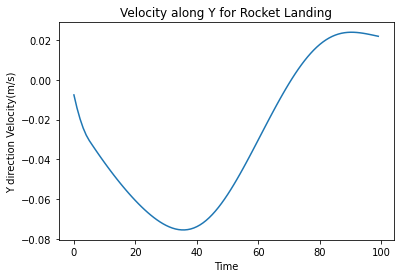

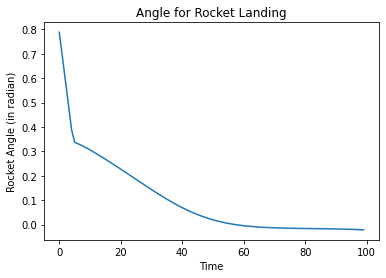

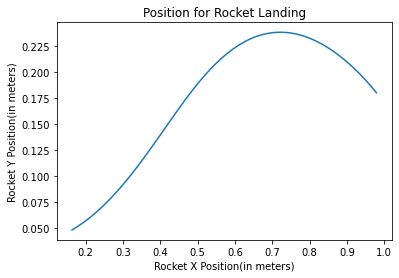

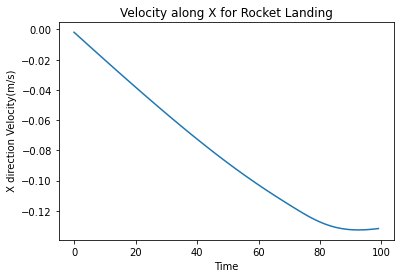

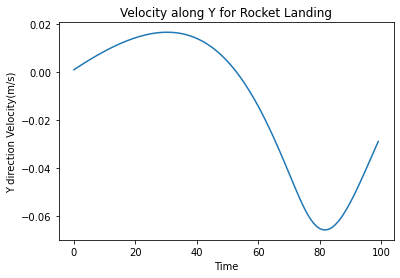

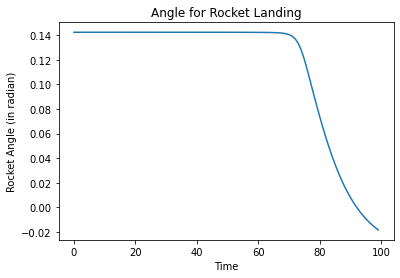

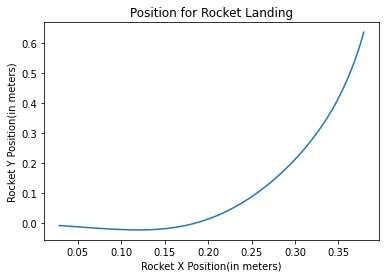

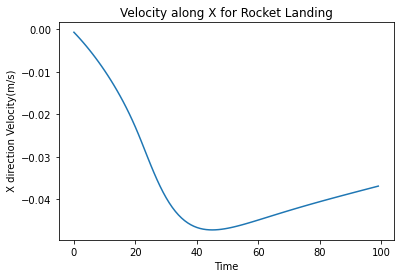

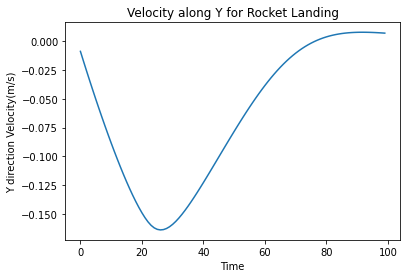

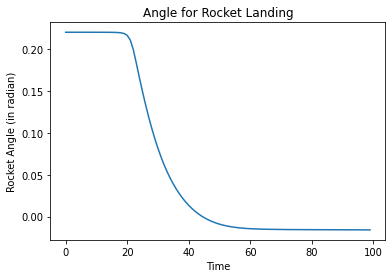

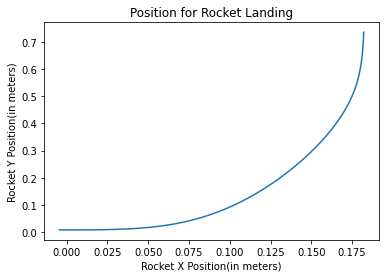

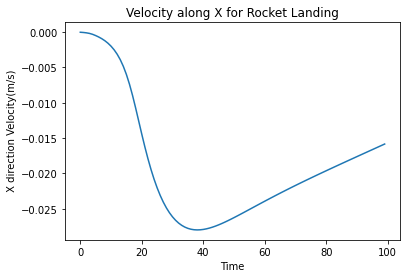

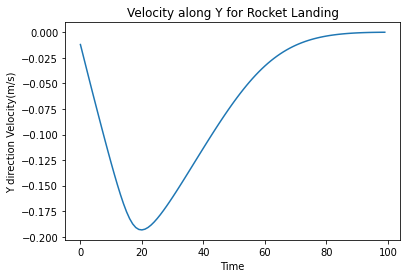

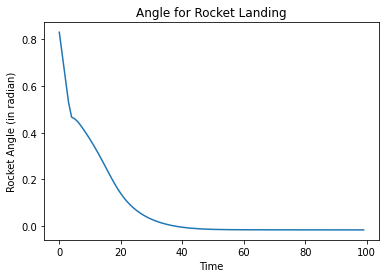

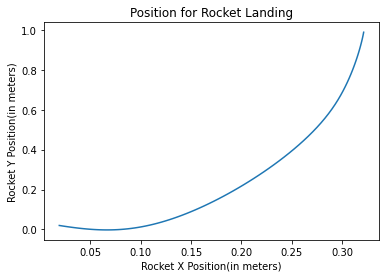

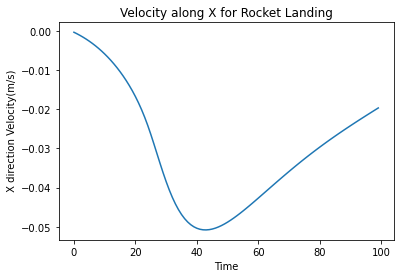

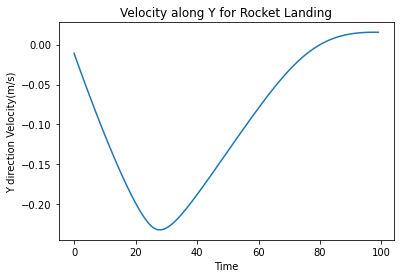

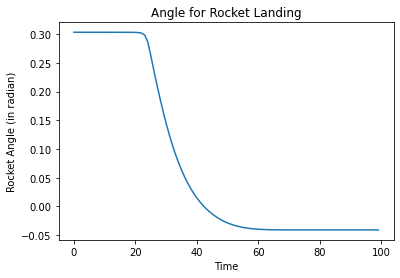

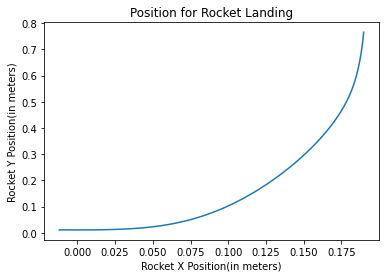

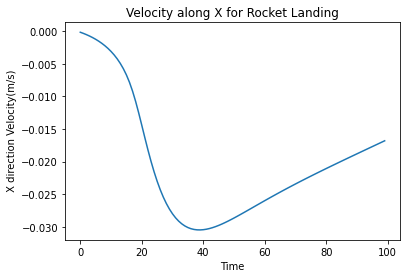

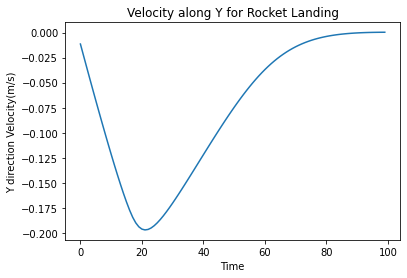

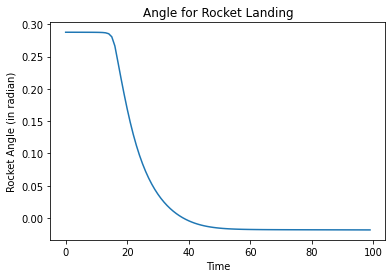

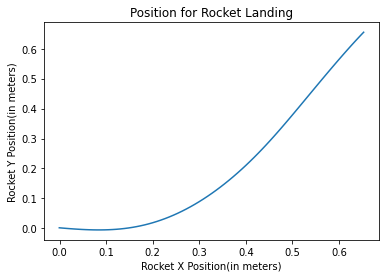

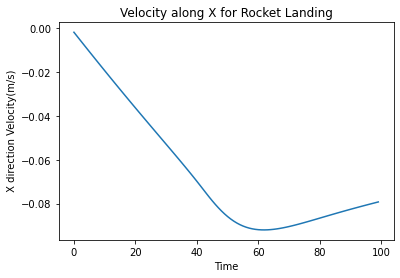

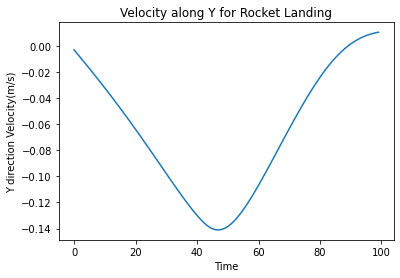

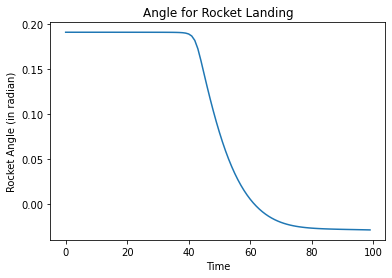

In [6]:
# Testing starts
N = 10  # number of samples  for random case
T = 100  # number of time steps
dim_input = 5  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T, N)  # define simulation, N is the number of samples to be considered
o = Optimize(s)  # define optimizer
o.train(50)  # solve the optimization problem